In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def loadSimpData():  # 读取数据集与对应的标签
    datMat = np.array([[1., 2.1],
                       [2., 1.1],
                       [1.3, 1.],
                       [1., 1.],
                       [2., 1.],
                       [1.8, 1.6],
                       [1.2, 1.2],
                       [1.9, 1.7]])
    classLabels = np.array([1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0])
    return datMat, classLabels

In [3]:
def loadDataSet(fileName):
    numFeat = len(open(fileName).readline().split('\t'))  # 通过分隔符分割数据
    dataMat = []  # 新建一个矩阵
    labelMat = []
    fr = open(fileName)  # 打开文件
    for line in fr.readlines():  # 读入每行的数据
        lineArr = []
        curLine = line.strip().split('\t')  # 通过分隔符分割数据
        for i in range(numFeat - 1):
            lineArr.append(float(curLine[i]))  # 将样本的属性存入lineArr
        dataMat.append(lineArr)  # 将所有样本的属性存入dataMat
        labelMat.append(float(curLine[-1]))  # 提取每行数据的标签
    return dataMat, labelMat

In [4]:
def stumpClassify(dataMatrix, dimen, threshVal, threshIneq):  # just classify the data
    retArray = np.ones((np.shape(dataMatrix)[0], 1)) # 创建一个和dataMatrix
    if threshIneq == 'lt':
        # 使该列中值小于或等于阈值的点类别为-1.0，其他为1.0
        retArray[dataMatrix[:, dimen] <= threshVal] = -1.0
    else:
        # 使该列中值大于阈值的点类别为-1.0，其他为1.0
        retArray[dataMatrix[:, dimen] > threshVal] = -1.0
    return retArray

In [5]:
def buildStump(dataArr, classLabels, D):
    dataMatrix = np.mat(dataArr)
    labelMat = np.mat(classLabels).T  # 转置标签向量
    m, n = np.shape(dataMatrix)  # 样本的行数列数
    numSteps = 10.0  # 初始化步数
    bestStump = {}  # 初始化决策树
    bestClasEst = np.mat(np.zeros((m, 1)))  # 默认类别为0
    minError = np.inf  # 初始化错误为无穷大
    for i in range(n):  # 遍历数据所有属性
        # 在当前属性中选取最小值
        rangeMin = dataMatrix[:, i].min()  
        # 在当前属性中选取最大值
        rangeMax = dataMatrix[:, i].max()  
         # 给定步数 计算步长
        stepSize = (rangeMax - rangeMin) / numSteps 
        # 在当前维度内循环步数次
        for j in range(-1, int(numSteps) + 1):  
            # 对值小于threshVal时分类分为为1.0还是-1.0两种情况进行遍历
            for inequal in ['lt', 'gt']:  
                # 计算阈值值threshVal
                threshVal = (rangeMin + float(j) * stepSize)  
                # 得到分类结果
                predictedVals = stumpClassify(dataMatrix, i, threshVal, inequal)
                # errArr默认为全1矩阵
                errArr = np.mat(np.ones((m, 1))) 
                # 比对分类结果与标签进行 分类正确为0 错误为1
                errArr[predictedVals == labelMat] = 0  
                # 计算加权后的误差
                weightedError = D.T * errArr  
                # 如果误差值小于最小误差
                if weightedError < minError:  
                    # 则更新最小误差为当前误差
                    minError = weightedError  
                    # 更新分类结果
                    bestClasEst = predictedVals.copy()  
                    # 更新最佳的决策树为当前信息
                    bestStump['dim'] = i  # i表示是以第1列还是第2列为分类依据
                    bestStump['thresh'] = threshVal
                    # inequal决定值小于threshVal分类为-1.0还是1.0
                    bestStump['ineq'] = inequal  
    return bestStump, minError, bestClasEst

In [52]:
def adaBoostTrainDS(dataArr, classLabels, numIt=50):
    weakClassArr = []  # 建立一个矩阵用于存放基学习器
    m = np.shape(dataArr)[0]
    D = np.mat(np.ones((m, 1)) / m)  # 初始化权值为1/m
    aggClassEst = np.mat(np.zeros((m, 1)))
    for i in range(numIt):
        bestStump, error, classEst = buildStump(dataArr, classLabels, D)  # 调用buildStump函数 建立决策树
        # 通过alpha的更新公式计算alpha
        alpha = float(0.5 * np.log((1.0 - error) / max(error, 1e-16)))
        bestStump['alpha'] = alpha
        weakClassArr.append(bestStump)  # 在数组中存放基学习器的信息
        # 计算自然底数幂次项
        expon = np.multiply(-1 * alpha * np.mat(classLabels).T, classEst)
        D = np.multiply(D, np.exp(expon))  # 更新权值D
        D = D / D.sum()  # 对新计算出的D进行归一化操作(即公式中/z)
        aggClassEst += alpha * classEst  # 计算更新后的分类结果

        aggErrors = np.multiply(np.sign(aggClassEst) != np.mat(classLabels).T, np.ones((m, 1)))
        errorRate = aggErrors.sum() / m
        if m >= 50:
            if i % 10 == 0 and i != 0:
                print("total error: ", errorRate, "({} / {})".format(i, numIt))
        else:
            print("total error: ", errorRate)
        if errorRate == 0.0:  # 如果错误率为0则直接跳出循环节省时间
            break 
    return weakClassArr, aggClassEst

In [53]:
def adaClassify(datToClass, labels, classifierArr):
    dataMatrix = np.mat(datToClass)  # do stuff similar to last aggClassEst in adaBoostTrainDS
    m = np.shape(dataMatrix)[0]
    aggClassEst = np.mat(np.zeros((m, 1)))
    for i in range(len(classifierArr)):
        classEst = stumpClassify(  # 调用stumpClassify函数进行预测
            dataMatrix,
            classifierArr[i]['dim'],  # 读入维度
            classifierArr[i]['thresh'],  # 读入阈值
            classifierArr[i]['ineq']  # 读入与阈值的大小关系
        )
        aggClassEst += classifierArr[i]['alpha'] * classEst  # 更新alpha值并累加至aggClassEst
    # 比对预测出类别与标签的差别 计算错误个数
    aggErrors = np.multiply(np.sign(aggClassEst) != np.mat(labels).T, np.ones((m, 1)))
    errorRate = aggErrors.sum() / m  # 计算错误率
    print("test error: ", errorRate)
    return np.sign(aggClassEst)  # 返回aggClassEst的符号值 即为预测的类别

In [54]:
def plotThis(dataMat, classLabels, weakClassArr):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    classLabels = np.array(classLabels)
    dataMat = np.array(dataMat)
    L1 = np.where(classLabels == 1)
    p1 = ax1.scatter(dataMat[L1, 0], dataMat[L1, 1], marker='+', color='r', label='1', s=50)
    L2 = np.where(classLabels == -1)
    p2 = ax1.scatter(dataMat[L2, 0], dataMat[L2, 1], marker='o', color='b', label='-1', s=50)

    for i in range(len(weakClassArr)):
        if weakClassArr[i]['dim'] == 0:
            ax1.axvline(x=weakClassArr[i]['thresh'], c="k", lw=2)
        if weakClassArr[i]['dim'] == 1:
            ax1.axhline(y=weakClassArr[i]['thresh'], c="k", lw=2)
    plt.ylabel('y-value')
    plt.xlabel('x-value')
    plt.show()

In [55]:
sampleMat, sampleLabel = loadSimpData()
sampleArr, _ = adaBoostTrainDS(sampleMat, sampleLabel)

[[-0.97295507]
 [ 0.97295507]
 [-0.97295507]
 [-0.97295507]
 [ 0.97295507]
 [ 0.97295507]
 [-0.97295507]
 [ 0.97295507]] 0.9729550745276566 [[-1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]]
total error:  0.125
[[-0.07707534]
 [ 1.86883481]
 [-1.86883481]
 [-1.86883481]
 [ 0.07707534]
 [ 1.86883481]
 [-0.07707534]
 [ 1.86883481]] 0.8958797346140276 [[ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]]
total error:  0.125
[[-0.52072694]
 [ 2.31248641]
 [-2.31248641]
 [-2.31248641]
 [ 0.52072694]
 [ 2.31248641]
 [-0.52072694]
 [ 2.31248641]] 0.44365159750045147 [[-1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]]
total error:  0.125
[[ 0.15423642]
 [ 1.63752305]
 [-2.98744977]
 [-2.98744977]
 [-0.15423642]
 [ 2.98744977]
 [-1.1956903 ]
 [ 2.98744977]] 0.6749633584745078 [[ 1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]]
total error:  0.125
[[ 1.02883635]
 [ 2.51212298]
 [-2.11284984]
 [-2.11284984]
 [ 0.72036351]
 [ 3.86204969]
 [-0.32109037]
 [ 3.86204969]] 0.87459992

In [43]:
for item in sampleArr:
    print(item)

{'dim': 0, 'thresh': 1.3, 'ineq': 'lt', 'alpha': 0.9729550745276566}
{'dim': 1, 'thresh': 1.0, 'ineq': 'lt', 'alpha': 0.8958797346140276}
{'dim': 0, 'thresh': 1.3, 'ineq': 'lt', 'alpha': 0.44365159750045147}
{'dim': 1, 'thresh': 1.22, 'ineq': 'lt', 'alpha': 0.6749633584745078}
{'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 0.8745999274046294}


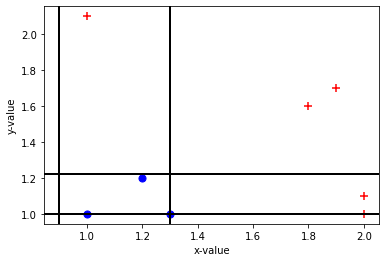

In [44]:
plotThis(sampleMat, sampleLabel, sampleArr)

In [45]:
trainMat, trainLabel = loadDataSet('horseColicTraining2.txt')
weakClassArr, _ = adaBoostTrainDS(trainMat, trainLabel)
testMat, testLabel = loadDataSet('horseColicTest2.txt')
adaClassify(testMat, testLabel, weakClassArr)

total error:  0.2408026755852843 (10 / 50)
total error:  0.2140468227424749 (20 / 50)
total error:  0.21070234113712374 (30 / 50)
total error:  0.20066889632107024 (40 / 50)
test error:  0.208955223880597


matrix([[ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 

In [26]:
weakClassArr

[{'dim': 9, 'thresh': 3.0, 'ineq': 'gt', 'alpha': 0.4616623792657674},
 {'dim': 17, 'thresh': 52.5, 'ineq': 'gt', 'alpha': 0.31248245042467104},
 {'dim': 3,
  'thresh': 55.199999999999996,
  'ineq': 'gt',
  'alpha': 0.2868097320169577},
 {'dim': 18,
  'thresh': 62.300000000000004,
  'ineq': 'lt',
  'alpha': 0.23297004638939506},
 {'dim': 10, 'thresh': 0.0, 'ineq': 'lt', 'alpha': 0.19803846151213741},
 {'dim': 5, 'thresh': 2.0, 'ineq': 'gt', 'alpha': 0.18847887349020634},
 {'dim': 12, 'thresh': 1.2, 'ineq': 'lt', 'alpha': 0.15227368997476778},
 {'dim': 7, 'thresh': 1.2, 'ineq': 'gt', 'alpha': 0.15510870821690512},
 {'dim': 5, 'thresh': 0.0, 'ineq': 'lt', 'alpha': 0.13536197353359405},
 {'dim': 4,
  'thresh': 28.799999999999997,
  'ineq': 'lt',
  'alpha': 0.12521587326132078},
 {'dim': 11, 'thresh': 2.0, 'ineq': 'gt', 'alpha': 0.1334764812820767},
 {'dim': 9, 'thresh': 4.0, 'ineq': 'lt', 'alpha': 0.1418224325377107},
 {'dim': 14, 'thresh': 0.0, 'ineq': 'gt', 'alpha': 0.10264268449708028}

In [21]:
def trainLogReg(dataMatIn, classLabels):
    # 定义sigmoid函数
    def sigmoid(z): return 1 / (1 + np.exp(z))
    # 转换为numpy型
    dataMatrix = np.mat(dataMatIn) 
    # 转化为矩阵[[0,1,0,1,0,1.....]]，并转制[[0],[1],[0].....] 
    # transpose() 行列转置函数
    # 将行向量转化为列向量   =>  矩阵的转置
    labelMat = np.mat(classLabels).transpose()
    # m->数据量，样本数 n->特征数
    m,n = np.shape(dataMatrix)
    alpha = 0.001 #步长
    maxCycles = 500 #迭代次数
    # 初始化权值向量，每个维度均为1.0
    weights = np.ones((n,1))
    for k in range(maxCycles):
        # 求当前sigmoid函数的值
        h = sigmoid(dataMatrix * weights)
        error = (labelMat - h)
        weights = weights + alpha * dataMatrix.transpose() * error
    return np.array(weights)

In [22]:
def logisticPredict(data, theta):
    prob = g(np.matmul(data, theta))
    if prob > 0.5:
        clas = 1
    else:
        clas = 0
    return prob, clas

In [23]:
weight = trainLogReg(trainMat, trainLabel)
_, res = logisticPredict(testMat, weight)

<ipython-input-21-6961f4ef0e16>:3: RuntimeWarning: overflow encountered in exp
  def sigmoid(z): return 1 / (1 + np.exp(z))


NameError: name 'g' is not defined

In [24]:
trainMat

[[2.0,
  1.0,
  38.5,
  66.0,
  28.0,
  3.0,
  3.0,
  0.0,
  2.0,
  5.0,
  4.0,
  4.0,
  0.0,
  0.0,
  0.0,
  3.0,
  5.0,
  45.0,
  8.4,
  0.0,
  0.0],
 [1.0,
  1.0,
  39.2,
  88.0,
  20.0,
  0.0,
  0.0,
  4.0,
  1.0,
  3.0,
  4.0,
  2.0,
  0.0,
  0.0,
  0.0,
  4.0,
  2.0,
  50.0,
  85.0,
  2.0,
  2.0],
 [2.0,
  1.0,
  38.3,
  40.0,
  24.0,
  1.0,
  1.0,
  3.0,
  1.0,
  3.0,
  3.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  33.0,
  6.7,
  0.0,
  0.0],
 [1.0,
  9.0,
  39.1,
  164.0,
  84.0,
  4.0,
  1.0,
  6.0,
  2.0,
  2.0,
  4.0,
  4.0,
  1.0,
  2.0,
  5.0,
  3.0,
  0.0,
  48.0,
  7.2,
  3.0,
  5.3],
 [2.0,
  1.0,
  37.3,
  104.0,
  35.0,
  0.0,
  0.0,
  6.0,
  2.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  74.0,
  7.4,
  0.0,
  0.0],
 [2.0,
  1.0,
  0.0,
  0.0,
  0.0,
  2.0,
  1.0,
  3.0,
  1.0,
  2.0,
  3.0,
  2.0,
  2.0,
  1.0,
  0.0,
  3.0,
  3.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [1.0,
  1.0,
  37.9,
  48.0,
  16.0,
  1.0,
  1.0,
  1.0,
  1.0,
  3.0,
  3.0,
  3.0,
  

In [63]:
import operator 

In [64]:
def classify0(inX, dataSet, labels, k):
    dataSetSize = dataSet.shape[0]  #返回数据集的行数
    #将输入向量按y轴方向复制数据集行数次，计算与原数据集的距离
    diffMat = np.tile(inX, (dataSetSize, 1)) - dataSet
    sqDiffMat = diffMat ** 2   #计算平方差
    sqDistances = sqDiffMat.sum(axis=1)   #对矩阵求和，计算平方距离
    distances = sqDistances ** 0.5   #再对平方距离差开根号
    sortedDistIndicies = distances.argsort()   #将distances中的元素从小到大排列，提取其对应的index
    classCount = {}
    for i in range(k):
        voteIlabel = labels[sortedDistIndicies[i]]
        classCount[voteIlabel] = classCount.get(voteIlabel, 0) + 1
    sortedClassCount = sorted(classCount.items(), key=operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0], classCount

In [87]:
def AdaBoostWithkNN(testArr, dataArr, classLabels, testLabels, numIt=40):
    weakClassArr = []  # 建立一个矩阵用于存放基学习器
    dataArr = np.array(dataArr)
    testArr = np.array(testArr)
    classLabels = np.array(classLabels)
    testLabels = np.array(testLabels)
    m = np.shape(testArr)[0]
    D = np.mat(np.ones((m, 1)) / m)  # 初始化权值为1/m
    aggClassEst = np.mat(np.zeros((m, 1)))
    alphaList = []
    result = []
    
    for i in range(1, numIt + 1):
        curres = []
        errornum = 0
        for t, sample in enumerate(testArr):
            res, _ = classify0(sample, dataArr, classLabels, i)
            curres.append(res)
            if res != classLabels[t]:
                errornum += 1
        error = errornum / len(testArr)
        # bestStump, error, classEst = buildStump(dataArr, classLabels, D)  # 调用buildStump函数 建立决策树
        # 通过alpha的更新公式计算alpha
        alpha = float(0.5 * np.log((1.0 - error) / max(error, 1e-16)))
        alphaList.append(alpha)
        result.append(curres)
        '''
        # 计算自然底数幂次项
        resultN = np.array(result)
        expon = np.multiply(-1 * alpha * np.mat(testLabels).T, resultN[:, np.newaxis])
        D = np.multiply(D, np.exp(expon))  # 更新权值D
        D = D / D.sum()  # 对新计算出的D进行归一化操作(即公式中/z)
        aggClassEst += alpha * resultN[:, np.newaxis]  # 计算更新后的分类结果

        aggErrors = np.multiply(np.sign(aggClassEst) != np.mat(testLabels).T, np.ones((m, 1)))
        errorRate = aggErrors.sum() / m

        if m >= 50:
            if i % 10 == 0 and i != 0:
                print("total error: ", errorRate, "({} / {})".format(i, numIt))
        else:
            print("total error: ", errorRate)
        

        print("total error: ", errorRate)
        if errorRate == 0.0:  # 如果错误率为0则直接跳出循环节省时间
            break
        '''
    alphaList = np.array(alphaList)
    finalres = np.sum(np.array(result)*alphaList[:, np.newaxis], axis=1)  
    print(finalres)
    return weakClassArr

In [88]:
AdaBoostWithkNN(testMat, trainMat, trainLabel, testLabel)

[-7.05987069 -7.05987069 -2.83122717 -2.83122717 -2.2974678  -4.12694718
 -3.91920978 -4.47332134 -4.91303235 -4.12694718 -4.91303235 -4.47332134
 -5.69911753 -5.13603561 -3.91920978 -4.45979044 -4.47332134 -6.14891964
 -5.13603561 -5.13603561 -5.13603561 -5.13603561 -5.13603561 -5.69911753
 -4.45979044 -5.13603561 -3.67010929 -3.67010929 -3.67010929 -4.45979044
 -4.45979044 -4.45979044 -3.67010929 -3.67010929 -3.67010929 -2.76633708
 -3.67010929 -4.45979044 -4.45979044 -4.45979044]


[]